# Calculating the rate as a function of track length

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

To try match 1806.05991 we are going to consider the Halite material (since this is what they present). Halite is made of NaCl but we dont know the Cl form factor now so we use Na23 as a starting point.

In [126]:
E_list = np.logspace(0, 2, 10)
# m_x = 500.0 #GeV

def calcdRdE(ER_keV, m_x, cp, cn, **kwargs):
    #Load in the list of nuclear spins, atomic masses and mass fractions
    nuclei_Halite = ["Na23"]
    frac_list_Halite = [1.0]
    frac_vals = dict(zip(nuclei_Halite, frac_list_Halite))

    dRdE = np.zeros_like(ER_keV)
    for nuc in nuclei_Halite:
        dRdE += frac_vals[nuc]*DMU.dRdE_NREFT(ER_keV, m_x, cp, cn, nuc, **kwargs)
    return dRdE

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


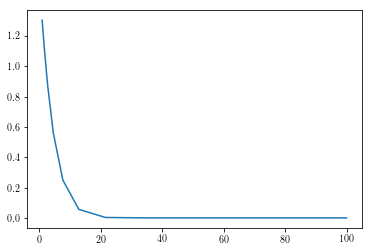

In [127]:
cp = np.zeros(11)
cp[0] = 1e-6
cn = cp

dRdE = calcdRdE(E_list, 10, cp, cn)
plt.plot(E_list, dRdE)
plt.show()

We have the recoil rate, as a function of recoil energy but the observable is actually the recoils as a function of track length. The translation is done using 

$$ x_t(E_R) = \int_0^{E_R} dE \left(\frac{dE}{dx_t}(E)\right)^{-1}$$

where $\frac{dE}{dx_t}$ is given by [this paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.15.2458),

$$ \frac{dE}{dx_t} = N \int_0^{T_m} T \sigma(T) dT$$

where $T_m = \gamma E$, $\gamma=\frac{4 M_1 M_2}{(M_1+M_2)^2}$, $\sigma(T) = \sigma(\theta)\frac{4 \pi}{\gamma E}$, $N$ is the atomic density of the target, $M1$ is the mass of the stopping nuclei, and $M_2$ is the mass of the target nuclei i.e. 23 GeV for Na23. $T = \gamma E\sin^2(\theta/2) $ and, finally, 

$$\theta = \pi - 2\int^\inf_{r_0} \frac{p dr}{r^2\left[1-V(r)/E_c-p^2/r^2\right]^{1/2}}$$

We also need $\sigma(\theta) = \frac{-p}{\sin\theta}\frac{dp}{d\theta}$, $E_c=\frac{E M_1}{(M_1+M_2)}$, $r_0$ is given by the root of $1-V(r)/E_c-p^2/r^2$

In [156]:
from scipy.integrate import quad
from scipy import optimize
# p is the impact parameter in nanometres
M_Ca = 23.*1.e6 # keV
m_DM = 100.*1.e6 # keV
ZCa = 11
e = 0.303
INVnm_to_keV = 0.197326979 # change inverse nanometres to keV (1 nm^-1 * hbar * c to keV)
V = lambda r: (ZCa**2.*e**2./r)*INVnm_to_keV # Add conversion factor to get V in keV

def calc_theta(p, E):
    Ec = M_Ca*E/(2*M_Ca)
    root = lambda r: 1-V(r)/Ec-p**2/r**2
    r0temp = optimize.brentq(root, 0.001, 100000)
    r0 = r0temp + 0.01*r0temp # for the numerics of the integral this needs to be slightly higher than the root
    
    integrand = lambda r: p/r**2./(1-V(r)/Ec-p**2/r**2)**0.5
    I = quad(integrand,r0,np.inf)[0]
    return np.pi - 2.*I

def calc_dpdtheta(p, E):
    Ec = M_Ca*E/(2*M_Ca)
    root = lambda r: 1-V(r)/Ec-p**2/r**2
    r0temp = optimize.brentq(root, 0.001, 100000)
    r0 = r0temp + 0.01*r0temp # for the numerics of the integral this needs to be slightly higher than the root
    
    dp = np.array([p-p*0.001,p,p+p*0.001])
    pdiv = np.zeros_like(dp)
    for i, ptemp in enumerate(dp):
        integrand = lambda r: ptemp/r**2./(1-V(r)/Ec-ptemp**2/r**2)**0.5
        pdiv[i] = -2*quad(integrand,r0,np.inf)[0]
    
    dpdtheta = np.gradient(pdiv)[1]
    return 1./dpdtheta

def calc_sigmaT(T, E, p):
    gamma = 4.*M_Ca**2./((2*M_Ca)**2.)
    theta = calc_theta(p, E)
    sigma_theta = -p*calc_dpdtheta(p, E)/np.sin(theta)
    return 4.*np.pi*sigma_theta/gamma/E

def calc_dEdx(E, p):
    N = 25.40902838311586 # N nm^-3
    gamma = 4.*M_Ca**2./((2.*M_Ca)**2.)
    Tm = gamma*E
    inte = lambda T: T*calc_sigmaT(T, E, p)
    return N*quad(inte, 0., Tm)[0]

In [164]:
cp = np.zeros(11)
cp[0] = 1e-6
cn = cp
m_dm = 10e6 # keV i.e. 10 GeV
p = 100. # Impact parameter in nm

################ Calculting the rate
dRdE = calcdRdE(E_list, m_dm, cp, cn)
dEdx = np.zeros_like(E_list)
for i,E in enumerate(E_list):
    dEdx[i] = calc_dEdx(E, p)

dRdx = dRdE*dEdx

################ Calculting the track lengths
xlist = np.zeros_like(E_list)
temp = lambda E: calc_dEdx(E, p)**-1
for i,E in enumerate(E_list):
    xlist[i] = quad(temp,0,E)[0]

In [165]:
print(xlist, E_list)

[1.39218716e-06 1.52853610e-06 1.66076677e-06 1.79046884e-06
 1.91865760e-06 2.04586878e-06 2.17262934e-06 2.29888295e-06
 2.42501930e-06 2.55112193e-06] [  1.           1.66810054   2.7825594    4.64158883   7.74263683
  12.91549665  21.5443469   35.93813664  59.94842503 100.        ]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


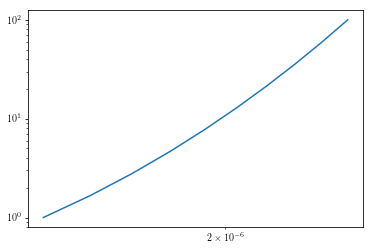

In [166]:
plt.loglog(xlist, E_list)
# plt.loglog(xlist, dEdx)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


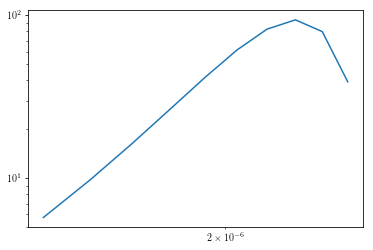

In [167]:
plt.loglog(xlist, dRdx)
# plt.ylabel(r"$dR/dx [nm^{−1} kg^{−1} yr^{−1}]$")
# plt.xlabel(r"$x [nm]$")
plt.show()